# Setting up the Development Environment

**Objective**

Set up the development environment with an NVIDIA GPU (whether local or remote), Jupyter Notebook and install the Python libraries that are listed below. Familiarize yourself with PyTorch, the deep learning framework that will be used throughout this project.



**Workflow**
Install the latest stable version of the software

1. Python
2. torch
3. torchvision
4. NumPy
5. sklearn
6. Matplotlib

Train a handwritten digit classifier using PyTorch. The choice of the network architecture is unrestricted, the goal is to simply get at **least 95% accuracy** on the test set! Note that the MNIST dataset is already available as part of the torchvision package.


**Importance to project**

Setting up the development environment and getting familiar with PyTorch syntax is a necessary preparation step for what is to come next. Training a deep convolutional GAN model for melanoma detection problem will prove to be computationally intensive, so fine-tuning the hyperparameters will all but require the use of a GPU.

Crucial imports

In [42]:
import numpy as np
import torch
import os
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import cv2
import tensorflow as tf
from PIL import Image
import PIL.ImageOps     # to invert color of images
import glob

Definitions of transformations performed on **MNIST data set images**.

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))])

Path to current working directory.

In [3]:
pat = os.path.abspath(os.getcwd())
print(pat)

/home/ricz/Desktop/Manning_books/Melanoma-detection


In [4]:
trainset = datasets.MNIST(pat, download = True, train = True, transform = transform)
valset = datasets.MNIST(pat, download = True, train = False, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
valloader = torch.utils.data.DataLoader(valset, batch_size = 64, shuffle = True)

Initial analysis of data set dimensions.

In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


Each image has dimensions **28x28 pixels** and each **batch has 64 images**. Script below displays some of them.

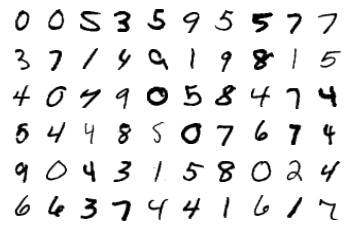

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

The following network will be built, containing an input layer (the first layer), an output layer of ten neurons (or units, the circles) and two hidden layers in between. A unit employing the rectifier, a rectified linear unit (ReLU), a simple function which allows positive values to pass through, whereas negative values are modified to zero.

784 units in the first layer are were calculated from flattened images matrices.

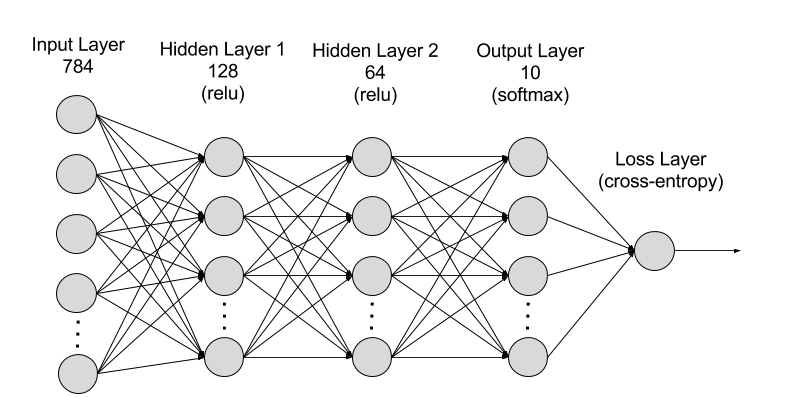

In [7]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax()
)


In [8]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

Visualisation of weights changes:

In [9]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[ 6.2140e-04,  6.2140e-04,  6.2140e-04,  ...,  6.2140e-04,
          6.2140e-04,  6.2140e-04],
        [-1.0000e-03, -1.0000e-03, -1.0000e-03,  ..., -1.0000e-03,
         -1.0000e-03, -1.0000e-03],
        [ 3.1977e-03,  3.1977e-03,  3.1977e-03,  ...,  3.1977e-03,
          3.1977e-03,  3.1977e-03],
        ...,
        [-2.9590e-03, -2.9590e-03, -2.9590e-03,  ..., -2.9590e-03,
         -2.9590e-03, -2.9590e-03],
        [ 4.6763e-05,  4.6763e-05,  4.6763e-05,  ...,  4.6763e-05,
          4.6763e-05,  4.6763e-05],
        [-1.7458e-03, -1.7458e-03, -1.7458e-03,  ..., -1.7458e-03,
         -1.7458e-03, -1.7458e-03]])


## Core Training Process

Script below makes use of **torch.optim** which is a module provided by PyTorch to optimize the model, **perform gradient descent and update the weights by back-propagation**. Thus in each **epoch (number of times we iterate over the training set)**, we will be seeing a gradual decrease in training loss.

In [54]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
losses = []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        # This is where the model learns by backpropagating
        loss.backward()
        
        # And optimizes its weights here
        optimizer.step()
        
        # To return the losses
        losses.append(loss.item())
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
        print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.048632748659823276

Training Time (in minutes) = 0.25638144413630165
Epoch 1 - Training loss: 0.045065134052566486

Training Time (in minutes) = 0.5261325438817342
Epoch 2 - Training loss: 0.042477532416266374

Training Time (in minutes) = 0.786802327632904
Epoch 3 - Training loss: 0.03771232308729042

Training Time (in minutes) = 1.0559628486633301
Epoch 4 - Training loss: 0.03570374418861731

Training Time (in minutes) = 1.365954577922821
Epoch 5 - Training loss: 0.03406463389551497

Training Time (in minutes) = 1.6264708638191223
Epoch 6 - Training loss: 0.03019528829061718

Training Time (in minutes) = 1.8924468676249186
Epoch 7 - Training loss: 0.029636430665418736

Training Time (in minutes) = 2.1631502072016398
Epoch 8 - Training loss: 0.02690029418843586

Training Time (in minutes) = 2.4412203272183737
Epoch 9 - Training loss: 0.02435289347922352

Training Time (in minutes) = 2.727602410316467
Epoch 10 - Training loss: 0.023558604078360402

Training T

## Model evaluation

Utility function view_classify() shows the image and class probabilities that were predicted. 

In [55]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()
    transform = transforms.ToPILImage()
    img = PIL.ImageOps.invert(transform(img))
    transform1 = transforms.ToTensor()
    img = transform1(img)
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze(), cmap = 'gray')
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 0


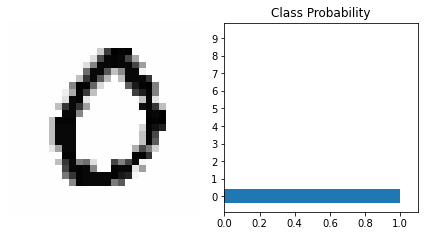

In [56]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

In [57]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9774


Saving the model

In [58]:
torch.save(model, './digit_recognition.pt') 

Plotting **model convergence from losses** extracted during traning session.

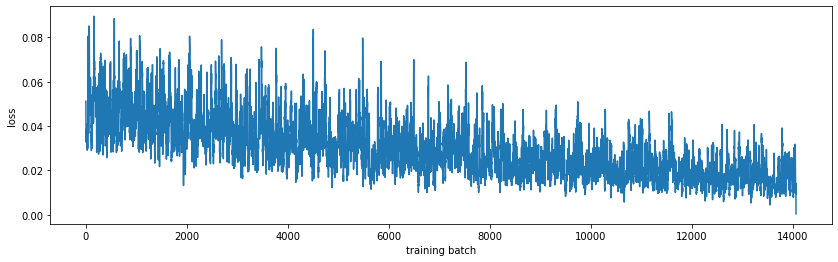

In [60]:
def mean(li): return sum(li)/len(li)
plt.figure(figsize=(14, 4));
plt.xlabel('training batch');
plt.ylabel('loss');
plt.plot([mean(losses[i:i+10]) for i in range(len(losses))]);

## Attempt to analyse personal samples using pretrained model from MNIST dataset

To further play with this model lets try new image of digit.

In [39]:
img = os.getcwd() + '/seven.jpg'
im = Image.open(img).convert('L')
size = 28, 28
im = im.resize((28, 28), Image.ANTIALIAS)
im = PIL.ImageOps.invert(im)    # to invert the image color and pass it to model
display(im)    # IPython's Module: display
transform1 = transforms.ToTensor()
img = transform1(im)
print('Size of image after resizing: ', img.shape)

Size of image after resizing:  torch.Size([1, 28, 28])


Predicted Digit = 2


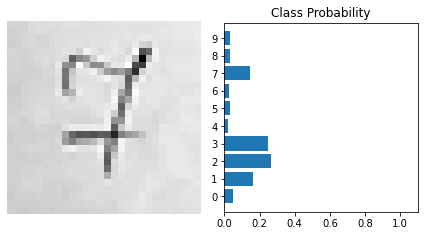

In [40]:
img = img.view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

Model failed when new, lower quality photo was presented. Another six photos were taken.

Size of image after resizing:  torch.Size([1, 28, 28])
Predicted Digit = 2


Size of image after resizing:  torch.Size([1, 28, 28])
Predicted Digit = 3


Size of image after resizing:  torch.Size([1, 28, 28])
Predicted Digit = 2


Size of image after resizing:  torch.Size([1, 28, 28])
Predicted Digit = 2


Size of image after resizing:  torch.Size([1, 28, 28])
Predicted Digit = 3


Size of image after resizing:  torch.Size([1, 28, 28])
Predicted Digit = 2


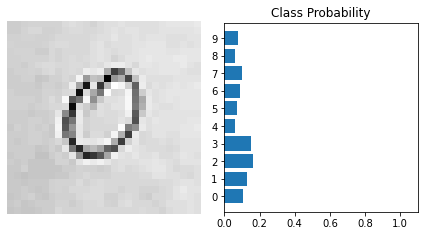

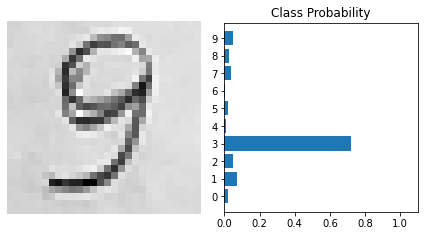

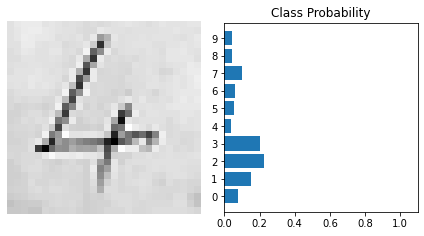

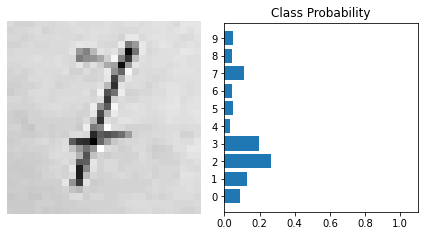

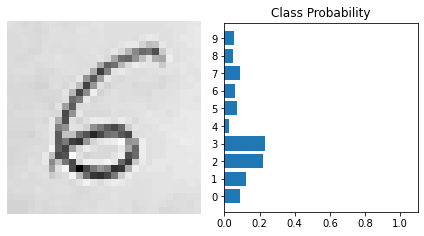

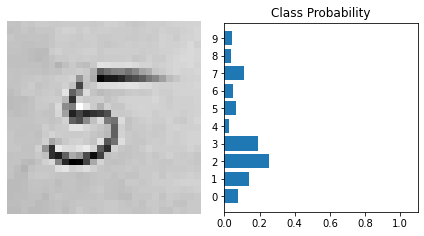

In [47]:
path = '/home/ricz/Desktop/Manning_books/Melanoma-detection/my_digits'

for image in glob.glob(path + '/*'): 
    img = image
    im = Image.open(img).convert('L')
    size = 28, 28
    im = im.resize((28, 28), Image.ANTIALIAS)
    im = PIL.ImageOps.invert(im)    # to invert the image color and pass it to model
    display(im)    # IPython's Module: display
    transform1 = transforms.ToTensor()
    img = transform1(im)
    print('Size of image after resizing: ', img.shape)
    img = img.view(1, 784)
    with torch.no_grad():
        logps = model(img)

    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    print("Predicted Digit =", probab.index(max(probab)))
    view_classify(img.view(1, 28, 28), ps)

Above attempt also failed. This can suggest that model has too weakly diversed training set. Another problem is probably the gray bacground of each new digit photo. 